<a href="https://colab.research.google.com/github/aminabykova/portfolio/blob/main/AB_tests_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HW1 Быкова Амина

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [121]:
df = pd.read_csv("ab_testing.csv")

print(df.head())

   User ID Group  Page Views  Time Spent Conversion   Device          Location
0    14292     B           3         424         No   Mobile  Northern Ireland
1    11682     A           9         342         No   Mobile          Scotland
2    19825     A           2         396         No  Desktop  Northern Ireland
3    16080     B           4         318         No  Desktop             Wales
4    18851     A           1         338        Yes  Desktop          Scotland


In [122]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB
None


**Гипотеза:** «Если фон веб-сайта сделать чёрным вместо белого, среднее время сессии пользователей увеличится»

# 1. Определение метрик
**Основная метрика:** Time Spent (среднее время сессии) — она напрямую связана с гипотезой.

**Дополнительная метрика:** Page Views (количество просмотренных страниц — не должно быть падения вовлеченности)

Она поможет понять побочные эффекты. Дополнительно стоит посмотреть разрезы по типу устройства и регионам, чтобы увидеть, везде ли наблюдается эффект.

**Safety метрика:** Conversion (конверсия не должна ухудшаться) и CR

Если время выросло, но конверсии упали — эксперимент нельзя считать успешным.

# 2. Проверка корректности запуска теста
### Проверка размеров групп

In [123]:
df['Group'].value_counts()

,count
Group,
A,2519
B,2481


In [124]:
df['Group'].value_counts(normalize=True)

,proportion
Group,
A,0.5038
B,0.4962


Группы примерно одинаковые по размеру.

### Проверка уникальности пользователей

In [125]:
df['User ID'].nunique(), len(df)

(5000, 5000)

Числа равные, значит, дубликатов нет.

### Проверка null значений

In [126]:
df.isnull().sum()

,0
User ID,0
Group,0
Page Views,0
Time Spent,0
Conversion,0
Device,0
Location,0


Null-значений нет.

### Проверка неестественных значений

In [127]:
df.describe()

,User ID,Page Views,Time Spent
count,5000.000000,5000.000000,5000.000000
mean,14925.159000,7.537600,242.512600
std,2869.153773,4.022465,118.254153
min,10001.000000,1.000000,40.000000
25%,12456.250000,4.000000,137.000000
50%,14858.500000,8.000000,243.000000
75%,17379.750000,11.000000,346.000000
max,19995.000000,14.000000,449.000000


In [128]:
print((df['Time Spent'] < 0).sum())
print((df['Page Views'] < 0).sum())

0
0


Аномальных значений тоже нет.

### Проверка распределения устройств и регионов по группам
#### Device

In [129]:
pd.crosstab(df['Group'], df['Device'], normalize='index')

Device,Desktop,Mobile
Group,,
A,0.493847,0.506153
B,0.521564,0.478436


In [130]:
# Статистическая проверка рандомизации (chi-square)
cont_table = pd.crosstab(df['Group'], df['Device'])
stats.chi2_contingency(cont_table)

Chi2ContingencyResult(statistic=np.float64(3.731765848529103), pvalue=np.float64(0.05338692515743378), dof=1, expected_freq=array([[1278.6444, 1240.3556],
       [1259.3556, 1221.6444]]))

p-value (0.053) > 0.05, следовательно, распределения одинаковы, рандомизация в порядке

#### Location

In [131]:
pd.crosstab(df['Group'], df['Location'], normalize='index')

Location,England,Northern Ireland,Scotland,Wales
Group,,,,
A,0.240572,0.243748,0.265979,0.249702
B,0.257960,0.253124,0.246272,0.242644


In [132]:
# Статистическая проверка рандомизации (chi-square)
cont_table = pd.crosstab(df['Group'], df['Location'])
stats.chi2_contingency(cont_table)

Chi2ContingencyResult(statistic=np.float64(4.10662577996627), pvalue=np.float64(0.2501782724258139), dof=3, expected_freq=array([[627.7348, 625.7196, 645.3678, 620.1778],
       [618.2652, 616.2804, 635.6322, 610.8222]]))

p-value (0.25) > 0.05, следовательно, распределения одинаковы, рандомизация в порядке

### Парные или независимые выборки
Проверяем, встречается ли один пользователь в обеих группах.

In [133]:
users_A = set(df[df['Group'] == 'A']['User ID'])
users_B = set(df[df['Group'] == 'B']['User ID'])

len(users_A.intersection(users_B))

0

Пересечений между пользователями в группах нет, значит, выборки независимые.

# 3. Исследование распределения основной метрики

In [134]:
group_A = df[df['Group'] == 'A']['Time Spent']
group_B = df[df['Group'] == 'B']['Time Spent']

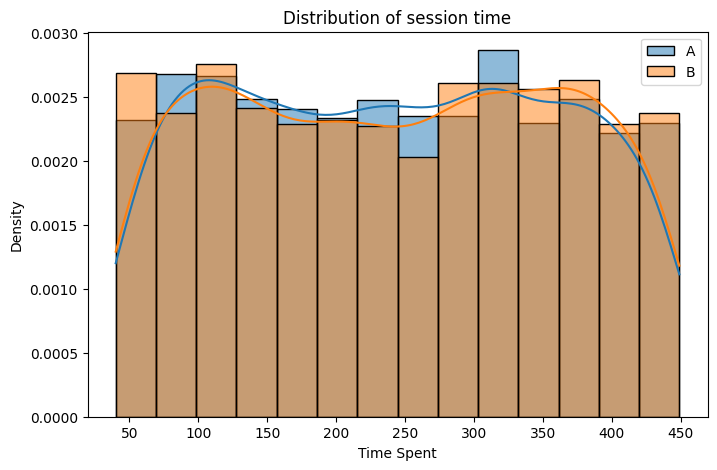

In [135]:
# Визуализация распределений
plt.figure(figsize=(8,5))
sns.histplot(group_A, kde=True, label='A', stat="density")
sns.histplot(group_B, kde=True, label='B', stat="density")
plt.legend()
plt.title("Distribution of session time")
plt.show()

In [136]:
# Проверка нормальности (Shapiro)
print(stats.shapiro(group_A))
print(stats.shapiro(group_B))

ShapiroResult(statistic=np.float64(0.9548671064698608), pvalue=np.float64(3.083246433138438e-27))
ShapiroResult(statistic=np.float64(0.9514252794431708), pvalue=np.float64(6.1796874034872095e-28))


Тест Шапиро-Уилка проверяет нулевую гипотезу (H0) о том, что выборка извлечена из нормально распределённой генеральной совокупности. Так как p << 0.05 для обоих групп, отвергаем H0. Крайне малые p‑value говорят о выраженном отклонении от нормального распределения.

In [137]:
# Проверка равенства дисперсий
stats.levene(group_A, group_B)

LeveneResult(statistic=np.float64(1.64873612875645), pvalue=np.float64(0.19919055717509185))

Тест Левена проверяет нулевую гипотезу (H0) о том, что дисперсии в двух группах равны. Так как p‑value > 0,05 (0,199), у нас нет оснований отвергнуть H0. Значит, дисперсии групп A и B статистически не различаются, можно считать их равными.

**Вывод:** несмотря на равные дисперсии групп, распределения не являются нормальными, поэтому корректнее будет применить непараметрический тест — **U‑критерий Манна-Уитни**.

# 4. Формулировка гипотез
**Для времени сессии** (основная метрика — Time Spent):

* H0: среднее время сессии одинаково в группах A и B (изменение фона не влияет на время).
* H1: время сессии в группе B больше, чем в группе A (черный фон увеличивает время сессии).

Тест: Mann-Whitney U (односторонний)

**Для просмотров страниц** (вторичная метрика — Page Views):
* H0: среднее количество просмотренных страниц одинаково в группах A и B.
* H1: среднее количество просмотренных страниц различается между группами A и B.

Тест: Mann-Whitney U (двусторонний)

**Для конверсии** (Safety метрика — Conversion):
* H0: группы A и B имеют одинаковую конверсию.
* H1: конверсии у сайтов с разным оформлением различаются.

Тест: хи-квадрат

# 5. Проведение статистических тестов

Для времени сессии (Time Spent):

In [138]:
stats.mannwhitneyu(group_B, group_A, alternative='greater')

MannwhitneyuResult(statistic=np.float64(3148544.0), pvalue=np.float64(0.3210150517016853))

In [139]:
mean_A = group_A.mean()
mean_B = group_B.mean()

diff = mean_B - mean_A

mean_A, mean_B, diff

(np.float64(241.73322747121873),
 np.float64(243.30390971382508),
 np.float64(1.5706822426063525))

Разница +1.57 сек (+0.65% к времени сессии). То есть эффект очень маленький, статистически незначимый и практически неощутимый.

/tmp/ipython-input-1197440653.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y= df['Time Spent'], x = df['Group'], palette=['tomato'])
/tmp/ipython-input-1197440653.py:1: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(y= df['Time Spent'], x = df['Group'], palette=['tomato'])


<Axes: xlabel='Group', ylabel='Time Spent'>

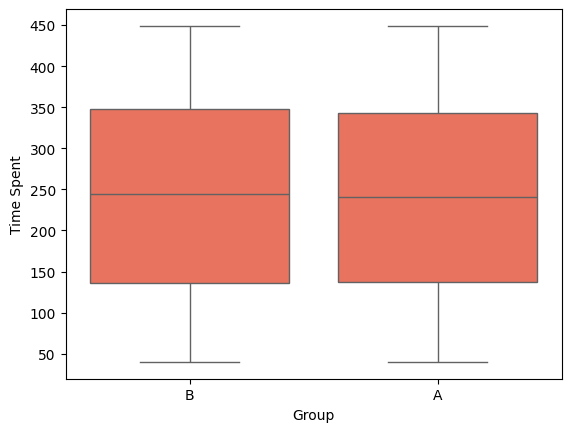

In [140]:
sns.boxplot(y= df['Time Spent'], x = df['Group'], palette=['tomato'])

Для просмотров страниц (Page Views):

In [141]:
group_A_views = df[df['Group'] == 'A']['Page Views']
group_B_views = df[df['Group'] == 'B']['Page Views']

stats.mannwhitneyu(group_B_views, group_A_views, alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(3084181.0), pvalue=np.float64(0.42467839841511335))

p-value = 0.425 > 0.05, следовательно, различий нет (H0 не отвергаем).

Для конверсии (Conversion):

In [142]:
conv_table = pd.crosstab(df['Group'], df['Conversion'])
conv_table

Conversion,No,Yes
Group,,
A,2383,136
B,2132,349


In [143]:
stats.chi2_contingency(conv_table)

Chi2ContingencyResult(statistic=np.float64(106.22812337440538), pvalue=np.float64(6.571736018334222e-25), dof=1, expected_freq=array([[2274.657,  244.343],
       [2240.343,  240.657]]))

p-value << 0.05. Нулевая гипотеза с уверенностью отклоняется.

In [144]:
conv_rate = conv_table.div(conv_table.sum(axis=1), axis=0)
conv_rate

Conversion,No,Yes
Group,,
A,0.946010,0.053990
B,0.859331,0.140669


Conversion Rate: A = 5.40%; B = 14.07%. Рост ≈ в 2.6 раза (+8.67 процентных пункта)

# 6. Статистический вывод
Изменение цвета фона сайта не приводит к статистически значимому увеличению времени пользовательской сессии.

Разница между группами составляет ~1.6 секунды (≈0.65%) и может быть объяснена случайными колебаниями выборки.

Эффект не обнаружен ни в общей выборке, ни в подгруппах пользователей.

При этом версия сайта с чёрным фоном приводит к статистически значимому и существенному увеличению safety метрики — конверсии пользователей (+8.67 п.п.).

# 7. Анализ по разрезам
#### По устройствам

In [145]:
for device in df['Device'].unique():
    sub = df[df['Device'] == device]

    A = sub[sub['Group']=='A']['Time Spent']
    B = sub[sub['Group']=='B']['Time Spent']

    stat, p = stats.mannwhitneyu(B, A, alternative='two-sided')

    print(device)
    print("mean A:", A.mean())
    print("mean B:", B.mean())
    print("p-value:", p)
    print()

Mobile
mean A: 240.3694117647059
mean B: 243.37573715248524
p-value: 0.5546975555240298

Desktop
mean A: 243.13102893890675
mean B: 243.23802163833076
p-value: 0.9559670784247916



Эффекта нигде нет. (p-value > 0.05: Mobile p = 0.55;
Desktop p = 0.96)

#### По регионам

In [146]:
for loc in df['Location'].unique():
    sub = df[df['Location'] == loc]

    A = sub[sub['Group']=='A']['Time Spent']
    B = sub[sub['Group']=='B']['Time Spent']

    stat, p = stats.mannwhitneyu(B, A, alternative='two-sided')

    print(loc)
    print("mean A:", A.mean())
    print("mean B:", B.mean())
    print("p-value:", p)
    print()

Northern Ireland
mean A: 238.66123778501628
mean B: 247.55891719745222
p-value: 0.1965071294879005

Scotland
mean A: 237.97014925373134
mean B: 230.2356792144026
p-value: 0.23218881104970635

Wales
mean A: 248.75993640699522
mean B: 245.1611295681063
p-value: 0.6230156863092247

England
mean A: 241.7128712871287
mean B: 249.8578125
p-value: 0.21961657089954334



По устройствам и регионам: нигде нет значимого роста времени, нет скрытых эффектов, результат стабильно нулевой.

# 8. Визуализации для бизнеса

#### Среднее время по группам

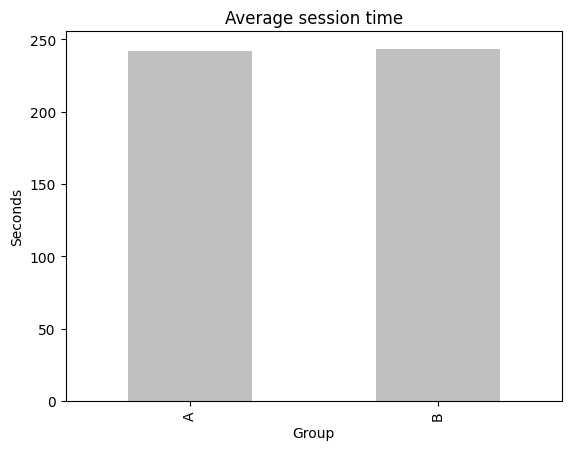

In [147]:
means = df.groupby('Group')['Time Spent'].mean()

means.plot(kind='bar', color=['silver'])
plt.title("Average session time")
plt.ylabel("Seconds")
plt.show()

#### Конверсия

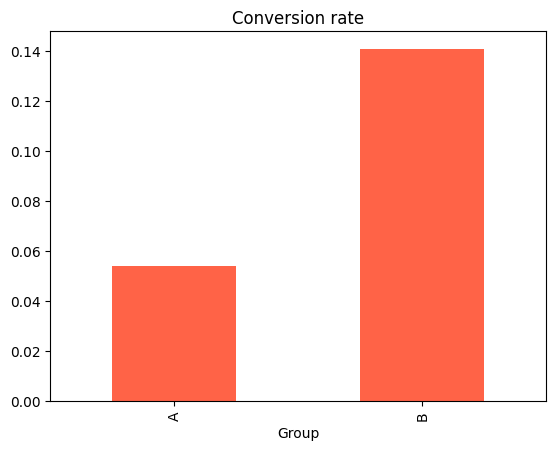

In [148]:
conv_rate['Yes'].plot(kind='bar', color=['tomato'])
plt.title("Conversion rate")
plt.show()

#### Время по устройствам

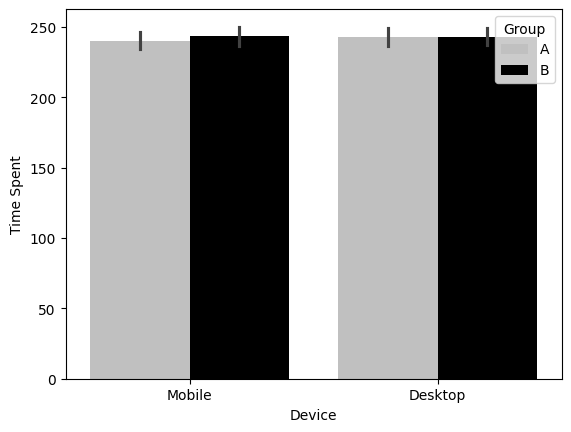

In [149]:
sns.barplot(data=df, x='Device', y='Time Spent', hue='Group', hue_order=['A', 'B'], palette=['silver', 'black'])
plt.show()

#### Время по регионам

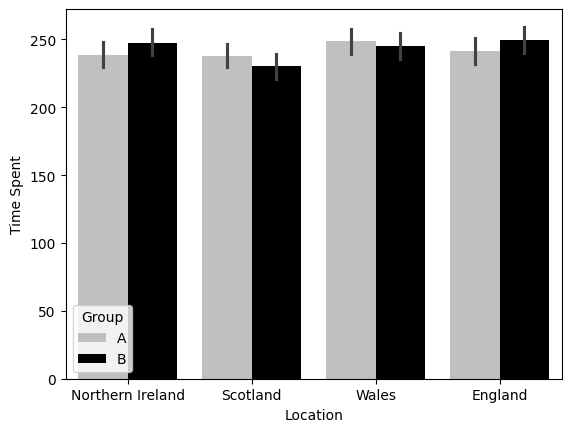

In [150]:
sns.barplot(data=df, x='Location', y='Time Spent', hue='Group', hue_order=['A', 'B'], palette=['silver', 'black'])
plt.show()

# 9. Выводы для бизнеса

**Что изменили:** фон сайта изменили с белого на чёрный.

**Что произошло:** время сессии не изменилось, но конверсия выросла с 5.4% до 14.1% (+8.7 п.п.).

**Насколько уверены:** изменения в конверсии крайне устойчивы; отсутствие влияния на время стабильно по сегментам.

**Что это дает бизнесу:** значительно больше пользователей совершают целевое действие; прямой рост выручки / продаж / заявок (в зависимости от цели конверсии).

**Что делать дальше:** рекомендовано раскатывать чёрный фон на всех пользователей, если метрика конверсии важна (но раскатывать изменение ради роста времени сессии не имеет смысла).

# 10. Рефлексия использования ИИ

ИИ использовался как инструмент структурирования аналитического процесса и проверки корректности кода и статистических процедур. Также я задавала уточняющие вопросы о том, как делаются те или иные проверки перед проведением тестов. В целом его работой я удовлетворена, но всегда перепроверяю и редактирую написанное. Планирую использовать для простых задач, которые уже умею делать сама.